# Basic DMDB Analysis

In [1]:
import pandas as pd
import networkx as nx
import yaml
from itertools import chain
from pathlib import Path
from operator import itemgetter
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from data_tools.files import download
from path_plots.dmdb_plots import plot_path
from data_tools.plotting import count_plot_h, venn2_pretty, venn3_pretty

/home/asu/env/DMDB_analysis/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Make the output folders
this_name = '1_basic_dmdb_analysis'
out_dir = Path('../2_pipeline').joinpath(this_name, 'out').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path('../0_data/external').resolve()
data_dir.mkdir(parents=True, exist_ok=True)

In [3]:
DMDB_URL = 'https://raw.githubusercontent.com/SuLab/DrugMechDB/main/indication_paths.yaml'
download(DMDB_URL, data_dir.joinpath('indication_paths.yaml'), redownload=False)

File indication_paths.yaml exits. Skipping...


In [4]:
with open(data_dir.joinpath('indication_paths.yaml'), 'r') as fh:
        ind = yaml.safe_load(fh)

In [5]:
def path_to_tup(path):
    return (path['graph']['drugbank'], path['graph']['disease_mesh'])

def path_to_G(path):
    return nx.node_link_graph(path)                                                                                        

def get_all_paths(path):
    source_id = path['links'][0]['source']                                                                              
    target_ids = list(set([l['target'] for l in path['links']]) - set([l['source'] for l in path['links']]))
    G = path_to_G(path)
    this_paths = list(chain(*[list(nx.all_simple_paths(G, source_id, target_id)) for target_id in target_ids]))         
    return this_paths

def get_id_to_type(G):
    id_to_type = {}
    for n in G.nodes.data():
        id_to_type[n[0]] = n[1]['label']
    return id_to_type

def get_id_to_name(G):
    id_to_name = {}
    for n in G.nodes.data():
        id_to_name[n[0]] = n[1]['name']
    return id_to_name

def add_metaedges(G):
    id_to_type = get_id_to_type(G)
    for e in G.edges:
        G.edges[e]['metaedge'] = id_to_type[e[0]] + ' - ' + e[2] + ' - ' + id_to_type[e[1]]
    return G

def add_meanode_pairs(G):
    id_to_type = get_id_to_type(G)
    for e in G.edges:
        G.edges[e]['mn_pair'] = id_to_type[e[0]] + ' - ' + id_to_type[e[1]]
    return G

def get_targets(G):
    drug = list(G.edges)[0][0]
    targets = []
    for e in G.edges:
        if e[0] == drug:
            targets.append(e[1])
    return targets

def get_target_metaedges(G):
    drug = list(G.edges)[0][0]
    target_mes = []
    if 'metaedge' not in G.edges[list(G.edges)[0]]:
        G = add_metaedges(G)
    
    for e in G.edges:
        if e[0] == drug:
            target_mes.append(G.edges[e]['metaedge'])
    return target_mes

### Things we'll explore in this notebook

-  Number of paths
-  Longest Path
-  Shortest path
-  Number of nodes
-  Number of edges

- most common metaedge
- most common pairing
- most common node
- common targets
- First edge type

In [6]:
basic_stats = defaultdict(list)
all_metaedges = []
all_parings = []
all_targets = []
unique_metaedges = []
first_edge_type = []
all_nodes = []

id_to_name = {}
id_to_label = {}

for i, p in enumerate(ind):
    drug_id, dis_id = path_to_tup(p)
    paths = get_all_paths(p)
    G = path_to_G(p)
    
    G = add_metaedges(G)
    G = add_meanode_pairs(G)
    
    basic_stats['idx'].append(i)
    basic_stats['drug'].append(drug_id)
    basic_stats['disease'].append(dis_id)
    basic_stats['n_nodes'].append(len(G.nodes))
    basic_stats['n_edges'].append(len(G.edges))
    basic_stats['n_paths'].append(len(paths))
    basic_stats['longest_path'].append(max([len(p) for p in paths]))
    basic_stats['shortest_path'].append(max([len(p) for p in paths]))
    basic_stats['metapath'].append(" - ".join([n[1]['label'] for n in G.nodes.data()]))
    
    this_metaedges = [G.edges[e]['metaedge'] for e in G.edges]
    all_metaedges += this_metaedges
    unique_metaedges += list(set(this_metaedges))
    
    all_parings += [G.edges[e]['mn_pair'] for e in G.edges]
    all_targets += get_targets(G)
    first_edge_type += get_target_metaedges(G)
    all_nodes += list(G.nodes)
    
    id_to_label = {**id_to_label, **get_id_to_type(G)}
    id_to_name = {**id_to_name, **get_id_to_name(G)}
    
basic_stats = pd.DataFrame(basic_stats)

In [7]:
basic_stats

,idx,drug,disease,n_nodes,n_edges,n_paths,longest_path,shortest_path,metapath
0,0,DB:DB00619,MESH:D015464,3,2,1,3,3,Drug - Protein - Disease
1,1,DB:DB00619,MESH:D034721,5,5,2,4,4,Drug - Protein - Protein - BiologicalProcess -...
2,2,DB:DB00316,MESH:D010146,6,7,3,4,4,Drug - Protein - Protein - Pathway - ChemicalS...
3,3,DB:DB00316,MESH:D005334,5,4,1,5,5,Drug - Pathway - GrossAnatomicalStructure - Bi...
4,4,DB:DB00945,MESH:D010146,5,5,2,4,4,Drug - Protein - Protein - ChemicalSubstance -...
...,...,...,...,...,...,...,...,...,...
3245,3245,DB:DB09104,MESH:D010437,4,3,1,4,4,Drug - ChemicalSubstance - ChemicalSubstance -...
3246,3246,DB:DB09104,MESH:D004415,5,4,1,5,5,Drug - ChemicalSubstance - ChemicalSubstance -...
3247,3247,DB:DB09104,MESH:D005764,4,3,1,4,4,Drug - ChemicalSubstance - ChemicalSubstance -...
3248,3248,DB:DB09104,MESH:D006356,4,3,1,4,4,Drug - ChemicalSubstance - ChemicalSubstance -...


In [8]:
print("Number of unique drugs: " + str(len(set(basic_stats['drug']))))
print("Number of unique diseases: " + str(len(set(basic_stats['disease']))))
print("Number of unique drug-disease combinations: " + str(len(basic_stats.groupby(['drug','disease']).size())))


Number of unique drugs: 1351
Number of unique diseases: 643
Number of unique drug-disease combinations: 2995


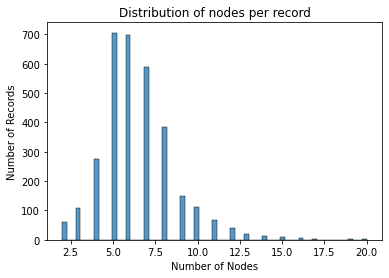

In [9]:
sns.histplot(basic_stats['n_nodes'])
plt.title('Distribution of nodes per record')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Records');

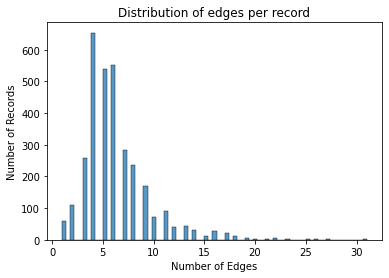

In [10]:
sns.histplot(basic_stats['n_edges'])
plt.title('Distribution of edges per record')
plt.xlabel('Number of Edges')
plt.ylabel('Number of Records');

/home/asu/env/DMDB_analysis/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


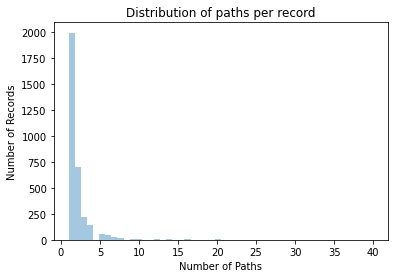

In [11]:
sns.distplot(basic_stats['n_paths'], kde=False)
plt.title('Distribution of paths per record')
plt.xlabel('Number of Paths')
plt.ylabel('Number of Records');

In [12]:
basic_stats.query('n_paths > 20')

,idx,drug,disease,n_nodes,n_edges,n_paths,longest_path,shortest_path,metapath
724,724,DB:DB05219,MESH:D003876,14,25,40,6,6,Drug - Protein - Protein - Protein - Protein -...
2442,2442,DB:DB00806,MESH:D016491,19,26,24,9,9,Drug - Protein - ChemicalSubstance - Biologica...


/home/asu/env/DMDB_analysis/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


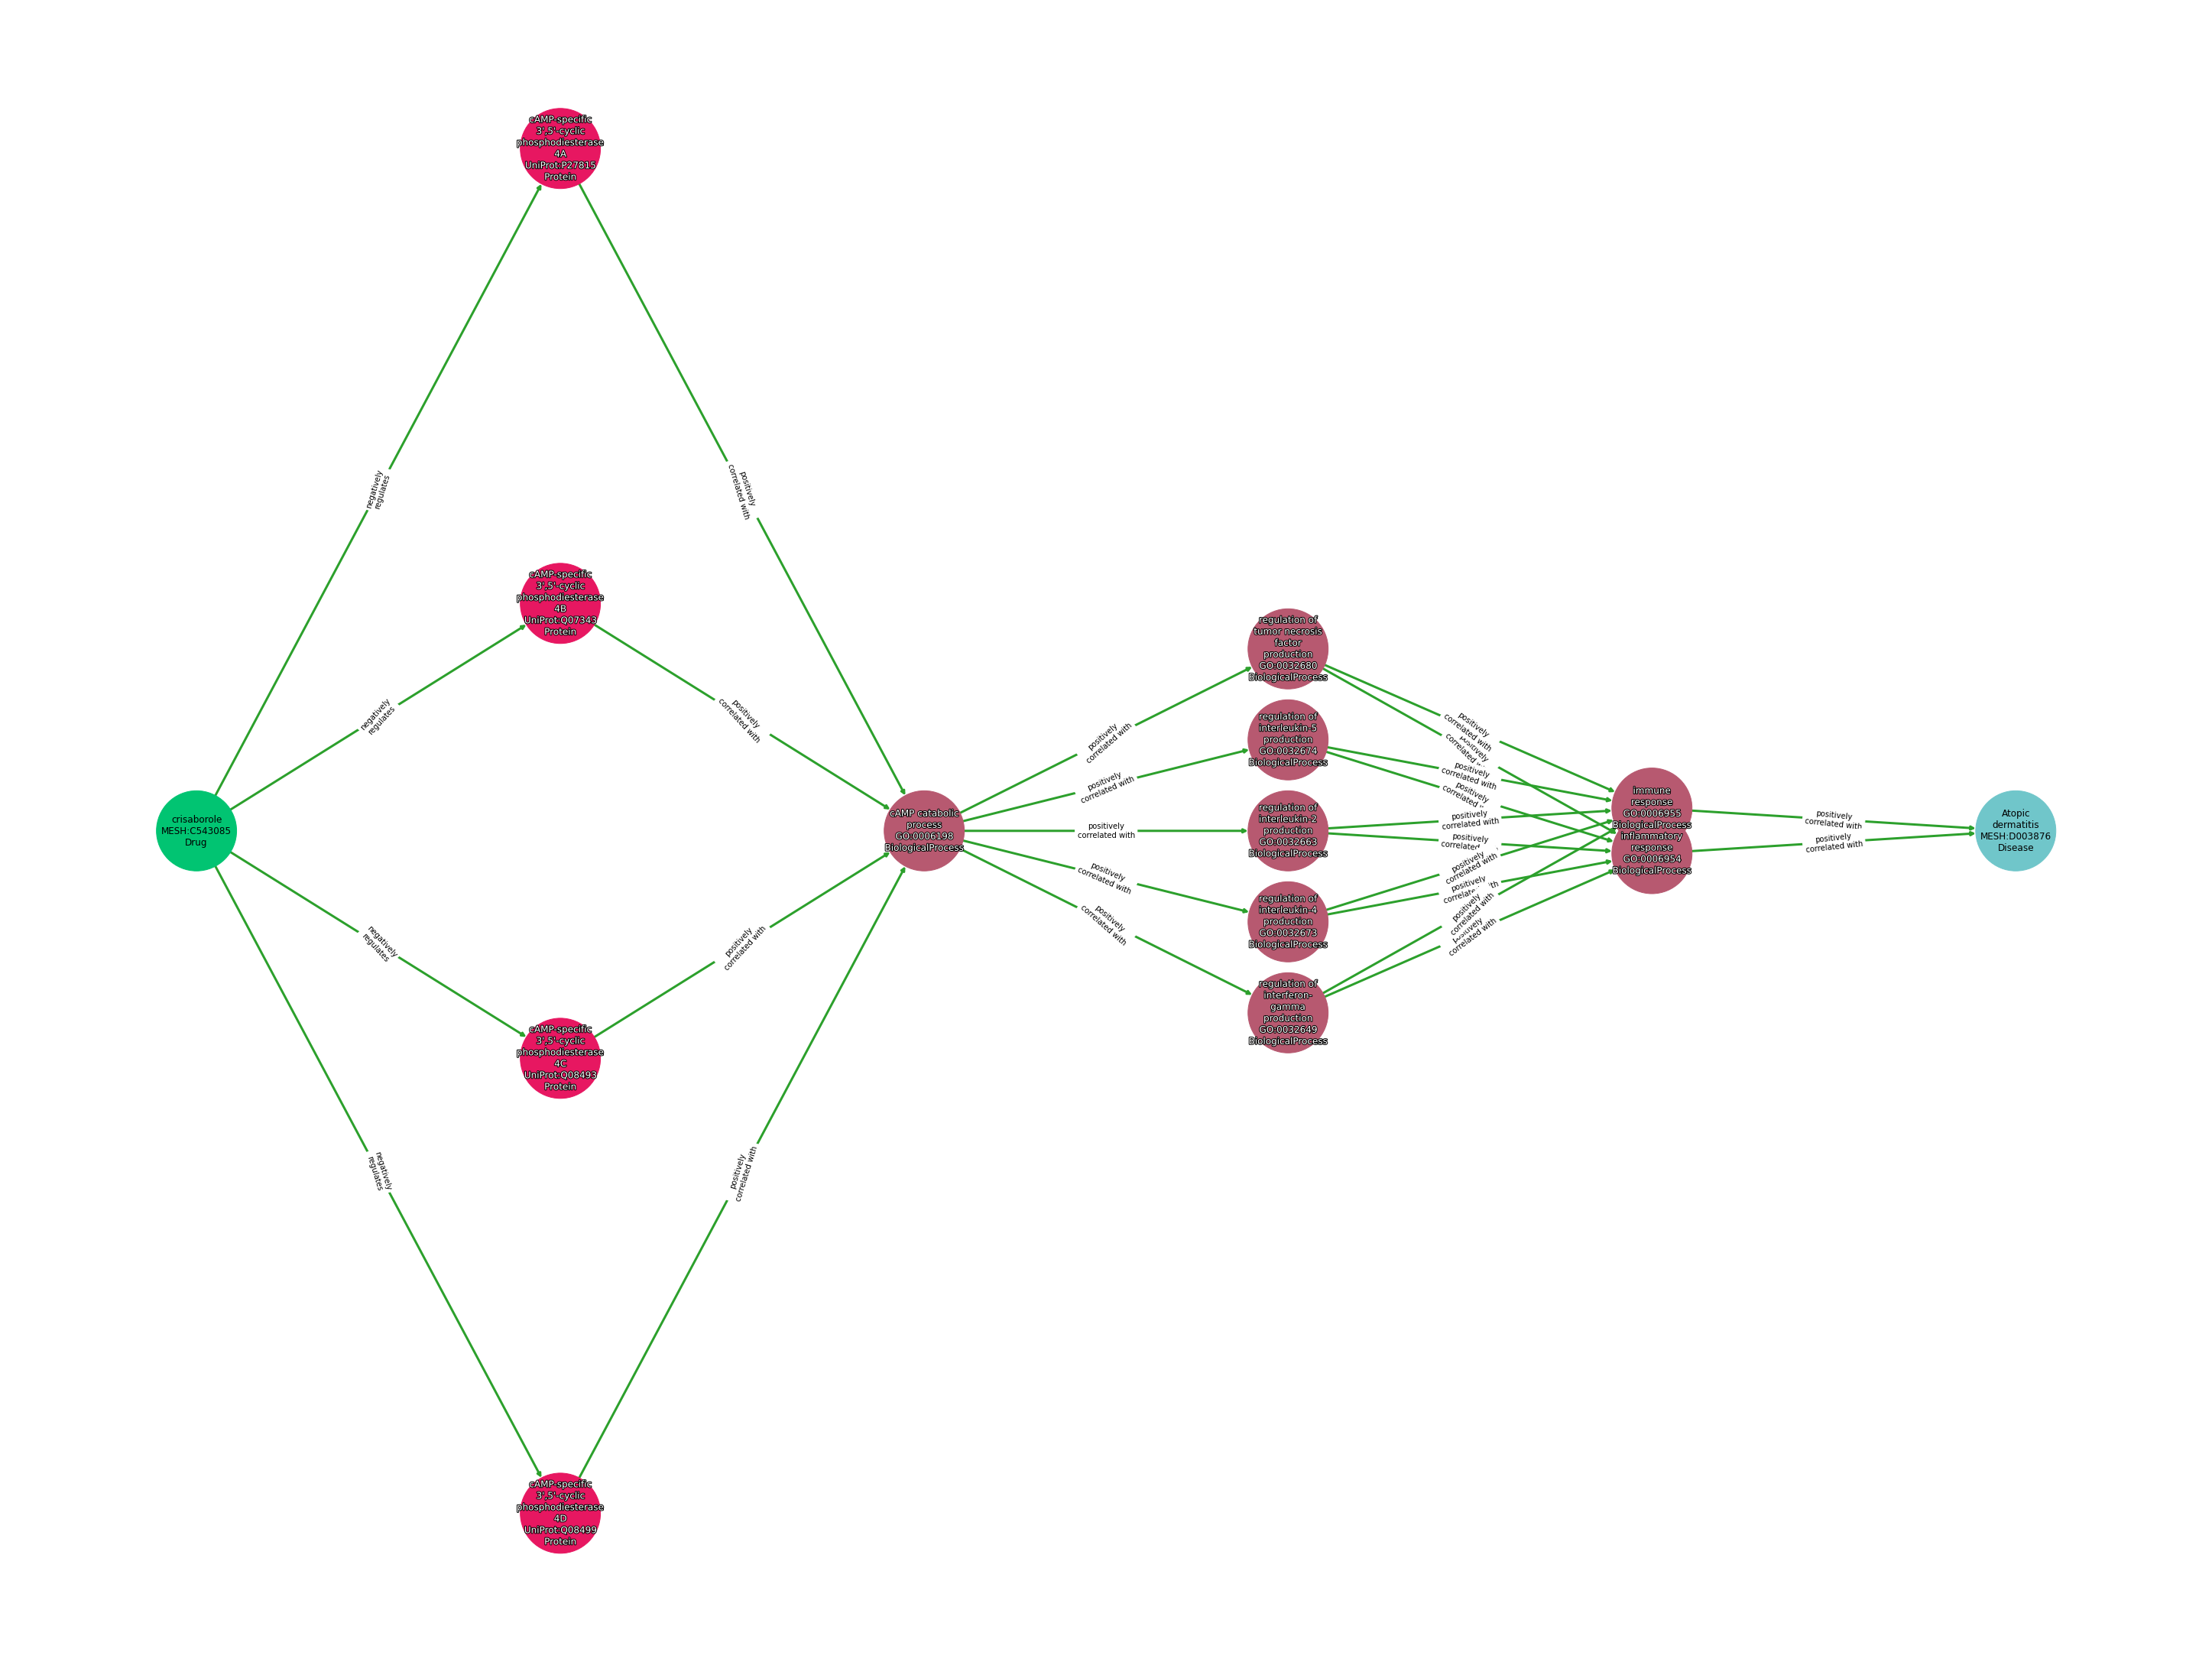

In [13]:
f = plot_path(ind[724])
f.set_size_inches(40, 30)

In [14]:
basic_stats.query('n_paths > 10')

,idx,drug,disease,n_nodes,n_edges,n_paths,longest_path,shortest_path,metapath
397,397,DB:DB08896,MESH:D006528,11,16,12,5,5,Disease - Protein - Protein - Protein - Protei...
517,517,DB:DB00799,MESH:D000152,13,31,20,5,5,Drug - Protein - Protein - Protein - Protein -...
518,518,DB:DB00799,MESH:D011565,10,20,12,5,5,Drug - Protein - Protein - Protein - Protein -...
724,724,DB:DB05219,MESH:D003876,14,25,40,6,6,Drug - Protein - Protein - Protein - Protein -...
733,733,DB:DB12323,MESH:D015464,10,17,12,5,5,Drug - Protein - Protein - GeneFamily - Molecu...
1204,1204,DB:DB11348,MESH:D010024,17,23,14,11,11,Drug - ChemicalSubstance - GeneFamily - Protei...
1205,1205,DB:DB11348,MESH:D006996,17,23,14,11,11,Drug - ChemicalSubstance - GeneFamily - Protei...
1206,1206,DB:DB11348,MESH:D015663,17,23,14,11,11,Drug - ChemicalSubstance - GeneFamily - Protei...
1253,1253,DB:DB00484,MESH:D012393,11,16,12,7,7,Drug - Protein - Protein - Protein - Pathway -...
1272,1272,DB:DB00484,MESH:D005902,12,17,12,8,8,Drug - Protein - Protein - Protein - Pathway -...


/home/asu/env/DMDB_analysis/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


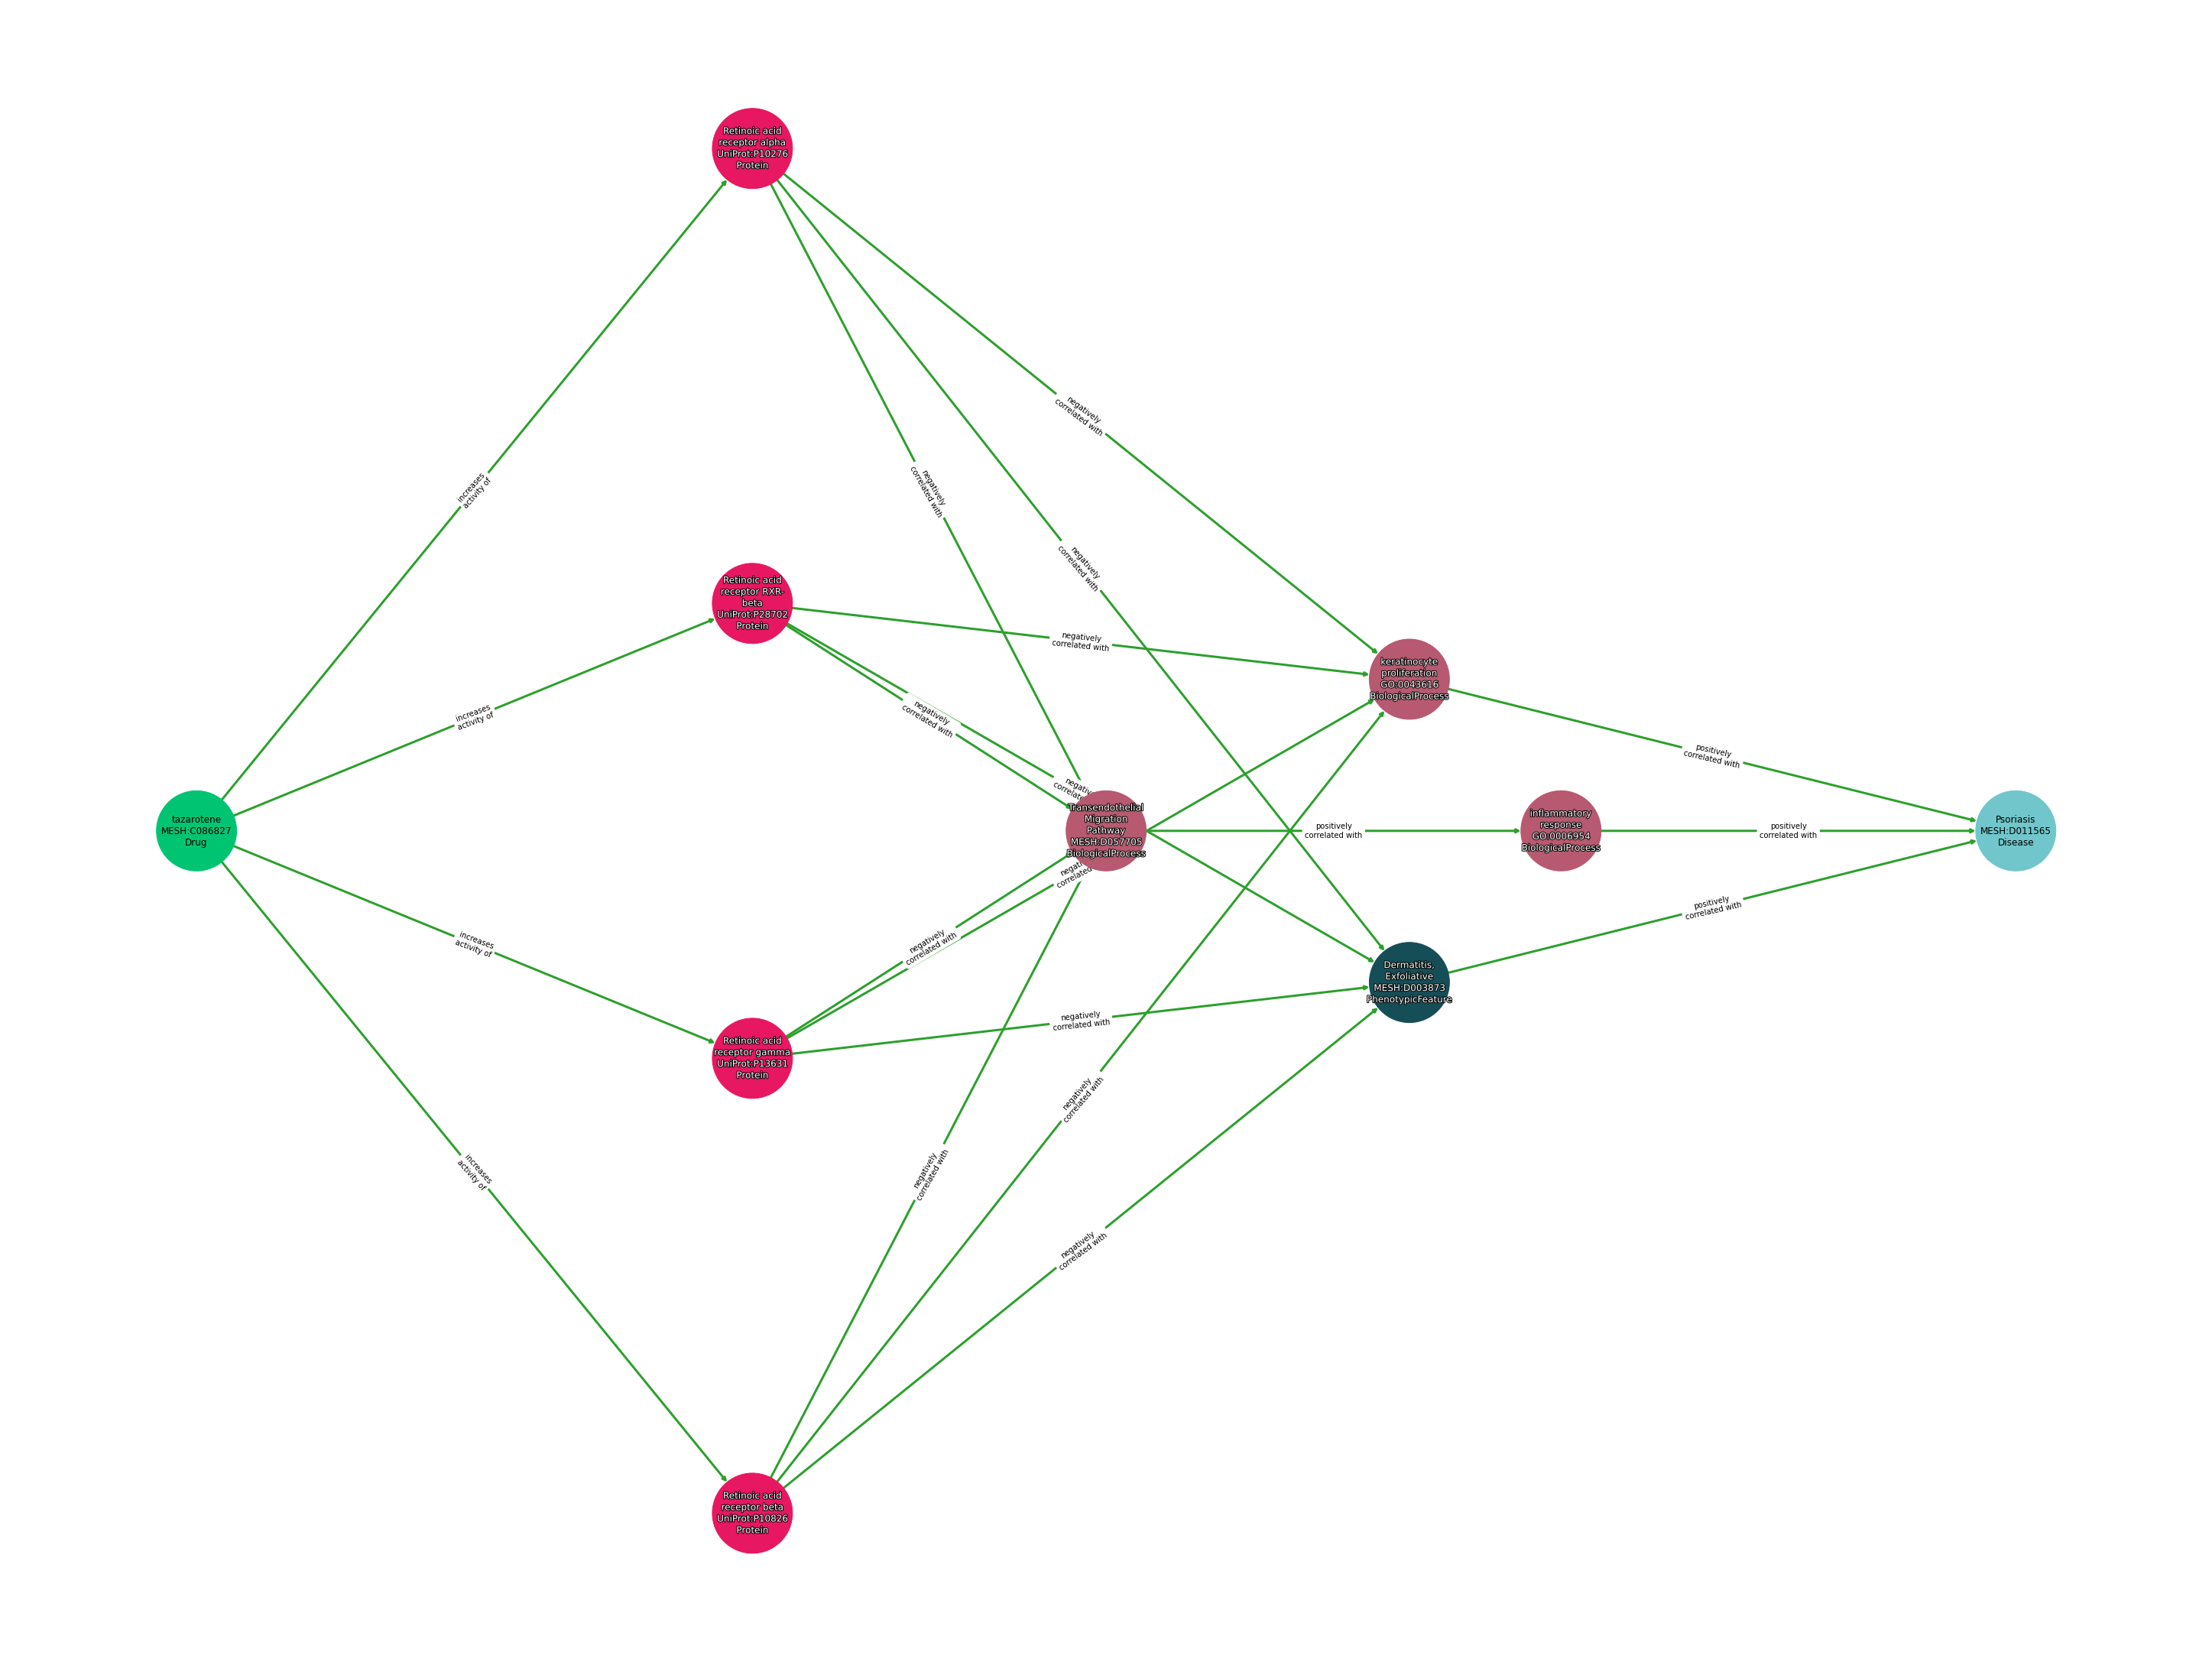

In [15]:
f = plot_path(ind[518])
f.set_size_inches(40, 30)

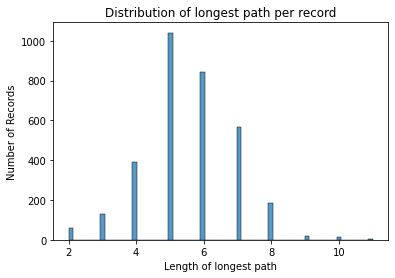

In [16]:
sns.histplot(basic_stats['longest_path'])
plt.title('Distribution of longest path per record')
plt.xlabel('Length of longest path')
plt.ylabel('Number of Records');

#### Metanode parings

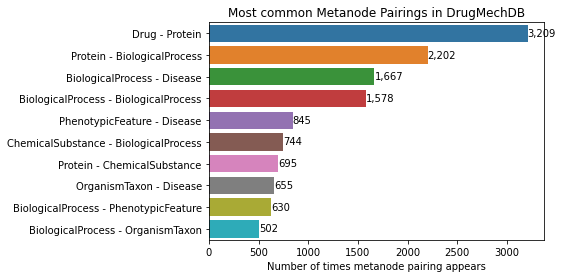

In [17]:
pair_counts = pd.Series(all_parings).value_counts()
count_plot_h(pair_counts.head(10))
plt.title('Most common Metanode Pairings in DrugMechDB')
plt.xlabel('Number of times metanode pairing appears');

#### Metaedge use

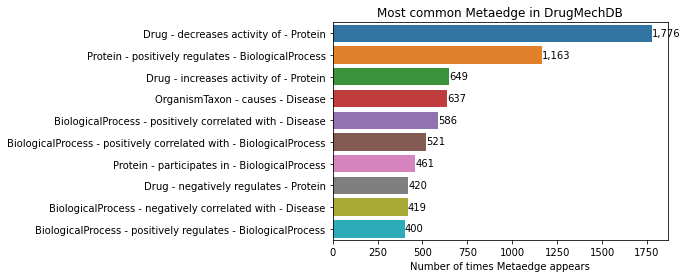

In [18]:
me_counts = pd.Series(all_metaedges).value_counts()
count_plot_h(me_counts.head(10))
plt.title('Most common Metaedge in DrugMechDB')
plt.xlabel('Number of times Metaedge appears');

#### Metaedges per record

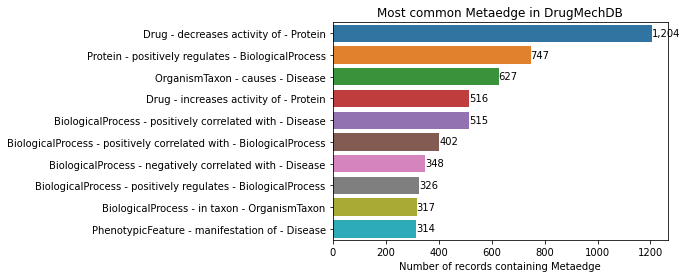

In [19]:
ume_counts = pd.Series(unique_metaedges).value_counts()
count_plot_h(ume_counts.head(10))
plt.title('Most common Metaedge in DrugMechDB')
plt.xlabel('Number of records containing Metaedge');

#### Metapaths

Text(0.5, 0, 'Number of records using metapath')

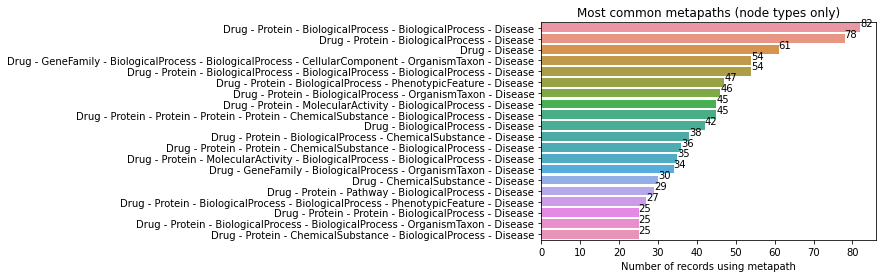

In [20]:
mp_counts = pd.Series(basic_stats['metapath']).value_counts()
count_plot_h(mp_counts.head(20))
plt.title('Most common metapaths (node types only)')
plt.xlabel('Number of records using metapath')

## Node information

In [21]:
node_counts = pd.Series(all_nodes, name='id')
node_counts = node_counts.to_frame().reset_index()
node_counts['name'] = node_counts['id'].map(id_to_name)
node_counts['label'] = node_counts['id'].map(id_to_label)

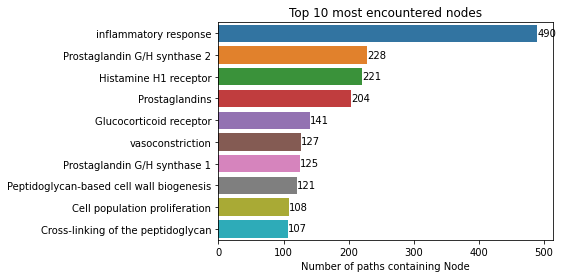

In [22]:
count_plot_h(node_counts['name'].value_counts().head(10))
plt.title('Top 10 most encountered nodes')
plt.xlabel('Number of paths containing Node')
plt.ylabel('');

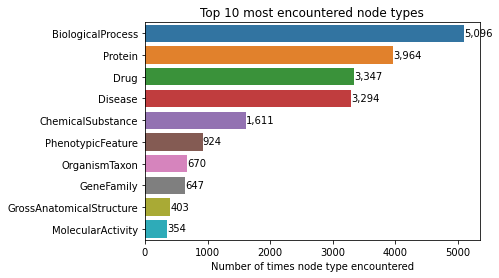

In [23]:
count_plot_h(node_counts['label'].value_counts().head(10))
plt.title('Top 10 most encountered node types')
plt.xlabel('Number of times node type encountered')
plt.ylabel('');

## Target Information

In [24]:
target_counts = pd.Series(all_targets, name='count')
target_counts = target_counts.value_counts().to_frame().reset_index().rename(columns={'index': 'id'})
target_counts['name'] = target_counts['id'].map(id_to_name)
target_counts['label'] = target_counts['id'].map(id_to_label)

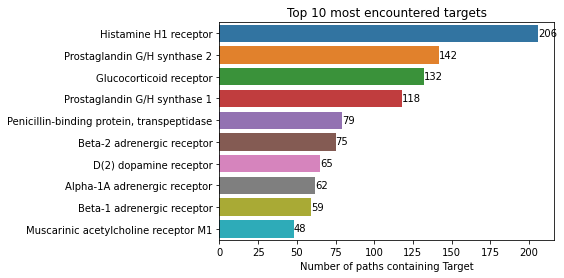

In [25]:
count_plot_h(target_counts.set_index('name').head(10)['count'])
plt.title('Top 10 most encountered targets')
plt.xlabel('Number of paths containing Target')
plt.ylabel('');

In [26]:
pd.Series(first_edge_type, name='type').to_frame()

,type
0,Drug - decreases activity of - Protein
1,Drug - decreases activity of - Protein
2,Drug - decreases activity of - Protein
3,Drug - decreases activity of - Protein
4,Drug - decreases activity of - Protein
...,...
4734,Drug - subclass of - ChemicalSubstance
4735,Drug - subclass of - ChemicalSubstance
4736,Drug - subclass of - ChemicalSubstance
4737,Drug - subclass of - ChemicalSubstance


In [27]:
fet_data = pd.Series(first_edge_type, name='type').to_frame()
fet_data['target_type'] = fet_data['type'].apply(lambda x: x.split(' - ')[2])
fet_data['interaction'] = fet_data['type'].apply(lambda x: x.split(' - ')[1])

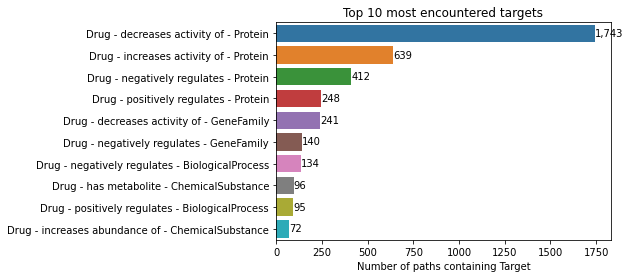

In [28]:
count_plot_h(fet_data['type'].value_counts().head(10))
plt.title('Top 10 most encountered targets')
plt.xlabel('Number of paths containing Target')
plt.ylabel('');

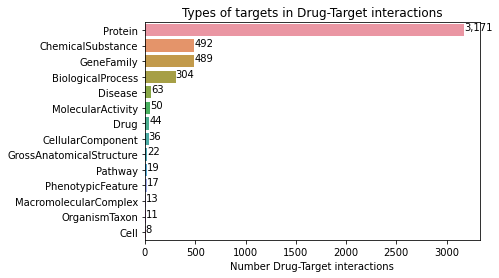

In [29]:
count_plot_h(fet_data['target_type'].value_counts())
plt.title('Types of targets in Drug-Target interactions')
plt.xlabel('Number Drug-Target interactions')
plt.ylabel('');

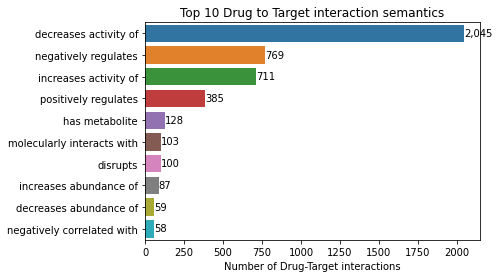

In [30]:
count_plot_h(fet_data['interaction'].value_counts().head(10))
plt.title('Top 10 Drug to Target interaction semantics')
plt.xlabel('Number of Drug-Target interactions')
plt.ylabel('');

## Full Graph Analysis

In [31]:
Graph = nx.MultiDiGraph()

for p in ind:
    G = path_to_G(p)
    Graph = nx.compose(Graph, G)

In [32]:
print(nx.info(Graph))

MultiDiGraph with 4582 nodes and 9389 edges


In [33]:
nx.density(Graph)

0.0004473052159437511

In [34]:
sgraph = nx.MultiGraph(Graph)

In [35]:
components = list(nx.connected_components(sgraph))
len(components)

23

In [36]:
larget_component = max(components, key=len)

In [37]:
subgraph = sgraph.subgraph(larget_component)

In [38]:
nx.diameter(subgraph)

21

In [39]:
degree_dict = dict(Graph.degree(Graph.nodes))
nx.set_node_attributes(Graph, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [40]:
node_degree = pd.DataFrame(sorted_degree).rename(columns={0: 'id', 1: 'degree'})
node_degree['name'] = node_degree['id'].map(id_to_name)

/home/asu/env/DMDB_analysis/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


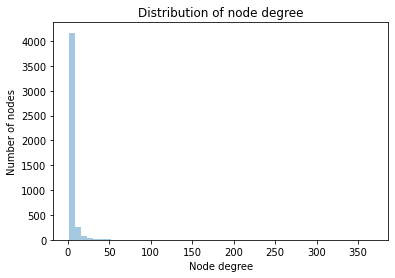

In [41]:
sns.distplot(node_degree['degree'], kde=False)
plt.title('Distribution of node degree')
plt.xlabel('Node degree')
plt.ylabel('Number of nodes');

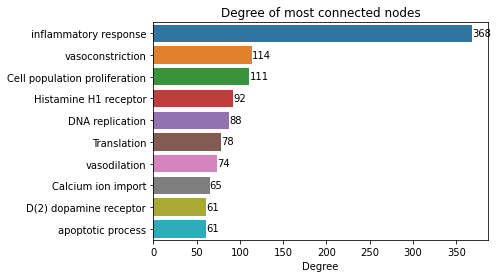

In [42]:
count_plot_h(node_degree.set_index('name')['degree'].head(10))
plt.title('Degree of most connected nodes');
plt.xlabel('Degree')
plt.ylabel('');